# Math 607 HW 4
### Sean Ericson 6/10/2024

In [1]:
# Imports
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,physics}'
mpl.rcParams["animation.html"] = "jshtml"

%matplotlib inline

## Ising Model

In [2]:
# Code
def Ising_Hamiltonian(σ, J, μ):
    n = σ.shape[0]
    return -J*sum([(σ[i, j]*σ[i, j+1] if j < n-1 else 0) + (σ[i, j]*σ[i+1, j] if i < n-1 else 0) for i in range(n) for j in range(n)]) -μ*σ.sum()

def neighbor_indices(n, i, j):
    nebs = []
    if i > 0:
        nebs.append((i-1, j))
    if j > 0:
        nebs.append((i, j-1))
    if i < n-1:
        nebs.append((i+1, j))
    if j < n-1:
        nebs.append((i, j+1))
    return nebs

def step_spins(σ, J, μ, β, site=None):
    n = σ.shape[0]
    if site is not None:
        i,j = site
    else:
        i,j = np.random.randint(n, size=2)
    neb_sum = sum([σ[x, y] for x,y in neighbor_indices(n, i, j)])
    ΔH = 2*σ[i,j]*(J*neb_sum + μ)
    prob = 1 if ΔH <= 0 else np.exp(-β*ΔH)
    if np.random.rand() < prob:
        σ[i,j] *= -1

def plot_spins(σ, ax):
    ax.axis('off')
    ax.imshow(σ, cmap="Greys", vmin=-1, vmax=1)

In [3]:
N = 20
high = np.ones((N,N))
low = -1*np.ones((N,N))
J = 1
μ = 1
β = 1
lows = [np.array(low)]
highs = [np.array(high)]
low_Hs = [Ising_Hamiltonian(low, J, μ)]
high_Hs = [Ising_Hamiltonian(high, J, μ)]
sample = None
while not np.array_equal(low, high):
    site = np.random.randint(N, size=2)
    step_spins(low, J, μ, β, site)
    step_spins(high, J, μ, β, site)
    lows.append(np.array(low))
    highs.append(np.array(high))
    low_Hs.append(Ising_Hamiltonian(lows[-1], J, μ))
    high_Hs.append(Ising_Hamiltonian(highs[-1], J, μ))

for _ in range(100):
    site = np.random.randint(N, size=2)
    step_spins(low, J, μ, β, site)
    step_spins(high, J, μ, β, site)
    lows.append(np.array(low))
    highs.append(np.array(high))
    low_Hs.append(Ising_Hamiltonian(lows[-1], J, μ))
    high_Hs.append(Ising_Hamiltonian(highs[-1], J, μ))

sample = lows[-1] if np.random.rand() < 0.5 else highs[-1]
print(len(lows))

13770


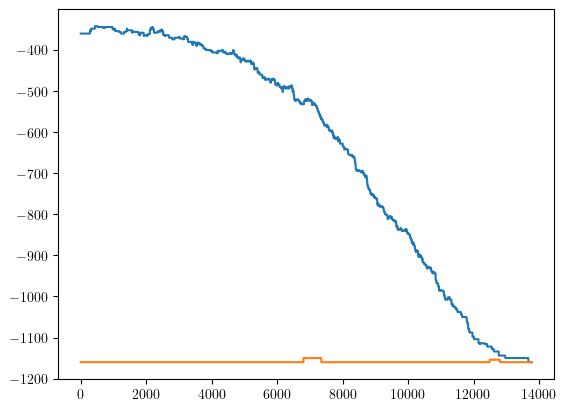

In [4]:
xs = list(range(len(lows)))
plt.plot(xs, low_Hs)
plt.plot(xs, high_Hs)

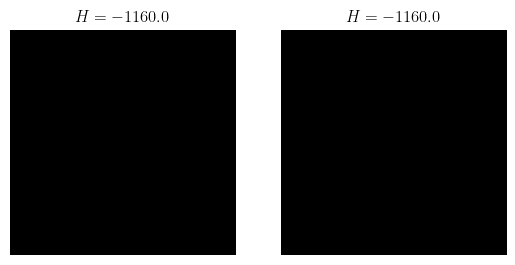

In [5]:
fig, ax = plt.subplots(1, 2)
plot_spins(lows[-1], ax[0])
plot_spins(highs[-1], ax[1])
ax[0].set_title("$H = {}$".format(low_Hs[-1]))
ax[1].set_title("$H = {}$".format(high_Hs[-1]))
plt.show()

In [6]:
fig, ax = plt.subplots(1, 2)
def update(frame):
    plt.cla()
    plot_spins(lows[frame], ax[0])
    plot_spins(highs[frame], ax[1])
    ax[0].set_title("$H = {}$".format(Ising_Hamiltonian(lows[0], J, μ)))
    ax[1].set_title("$H = {}$".format(Ising_Hamiltonian(highs[0], J, μ)))
    
anim = animation.FuncAnimation(fig, update, frames=range(0, len(lows), int(len(lows) / 100)), interval=20)
plt.close()

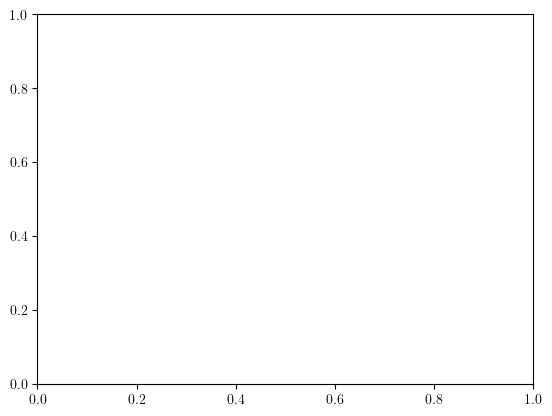

In [7]:
display(anim)

## Continuous time markov chains

### a)
The markov property
$$ \mathbb{P}(X_{l+1} = j \;|\; X_{l}=i, X_{l-1} = i_{l-1}, \ldots, X_0 = i_0) = \mathbb{P}(X_{t+1} = j\lvert X_{t}=i) $$
for discrete-time Markov chains already implies that
$$ \mathbb{P}(X_{t+s} = j \;|\; X_s = i, X_{s_0} = i_0, \ldots X_{s_n} = i_n) = \mathbb{P}(X_{t+s} = j \;|\; X_s = i), $$
i.e. it already gives us that the future is independent of the past, conditioned on the present. So, we just need to show that for a continuous-time Markov chain
$$ \mathbb{P}(X_{t+s} = j \;|\; X_s = i) = \mathbb{P}(X_{t} = j \;|\; X_0 = i). $$
Now, the probability $\mathbb{P}(X_{t+s} = j \;|\; X_s = i)$ depends on the number of transitions in the period $[s, s+t]$, $N([s, s+t])$. This number is distributed as
$$ \text{Poisson}(\mu([s, s+t])) = \text{Poisson}(\lambda(s+t-s)) = \text{Poisson}(\lambda t), $$
and clearly depends only on the length of the interval. Therefore,
$$ \mathbb{P}(X_{t+s} = j \;|\; X_s = i) = \mathbb{P}(X_{t} = j \;|\; X_0 = i), $$ 
and thus
$$ 
\mathbb{P}(X_{t+s} = j \;|\; X_s = i, X_{s_0} = i_0,  \ldots X_{s_n} = i_n) = \mathbb{P}(X_{t} = j \;|\; X_0 = i).
$$


### b)

$$ p_t(i,j) = \sum_{k=0}^\infty p_k^t \bra{j}A^k\ket{i}  $$
where
$$ p_k^t \coloneqq \frac{(t\lambda)^k e^{-\lambda t}}{k!} $$

$$
\begin{align*}
    \sum_{k}p_s(i,k)p_t(k,j) &= \sum_k \sum_{l=0}^\infty p_l^s \bra{k}A^l\ket{i} \sum_{m=0} p_m^t \bra{j}A^m\ket{k} \\
    &= \sum_{klm} p_l^s p_m^t \bra{j}A^l\ket{k}\bra{k}A^m\ket{i} \\
    &= \sum_{klm} p_l^s p_m^t \bra{j}A^{l+m}\ket{i} \\
    &= \bra{j} \left[\sum_{lm} p_l^s A^l p_m^t A^m \right] \ket{i} \\
    &= \bra{j} \left[\sum_{l=0}^\infty\sum_{m=0}^l p_m^s A^m p_{l-m}^t A^{l-m} \right] \ket{i} \\
    &= \sum_{l=0}^\infty\sum_{m=0}^l \frac{(t\lambda)^m e^{-\lambda t}}{m!}\frac{(s\lambda)^{l-m}e^{-\lambda s}}{(l-m)!} \bra{j}A^l\ket{i} \\
    &= \sum_{l=0}^\infty\sum_{m=0}^l \frac{t^m s^{l-m}}{m!(l-m)!} \lambda^l e^{-\lambda(s+t)} \bra{j}A^l\ket{i} \\
    &= \sum_l \frac{((s+t)\lambda)^l e^{-\lambda(s+t)}}{l!} \bra{j}A^l\ket{i} \\
    &= \sum_l p_l^{s+t} \bra{j}A^l\ket{i} \\
    &= p_{s+t}(i,j)
\end{align*}
$$

### c)
$$ 
\begin{align*}
    \mathbf{P}(N([0,h])) > 1 &= 1 - p(0) - p(1) \\
    &= 1 - e^{-\lambda h} - \lambda h e^{-\lambda h} \\
    &= 1 - (1 + \lambda h)e^{-\lambda h} \\
    &\approx 1 - (1 + \lambda h)(1 - \lambda h) \\
    &\approx \lambda^2 h^2
\end{align*}
$$

$$
\begin{align*}
    \frac{\text{d}}{\text{d}h} p_h(i,j)\rvert_{h=0} &= \frac{\text{d}}{\text{d}h} \left(e^{-\lambda h}\sum_l \frac{(\lambda h)^l}{l!}A_{ij}^l\right) \bigg\rvert_{h=0} \\
    &= e^{-\lambda h}\left(\sum_{l=1}^\infty \frac{\lambda^l h^{l-1}}{(l-1)!}A_{ij}^l - \lambda\sum_{l=0}^\infty\frac{(\lambda h)^l}{l!}A_{ij}^l \right)\bigg\rvert_{h=0} \\
    &= e^{-\lambda h}\sum_{l=0}^\infty \frac{\lambda^{l+1}h^l}{l!}\left(A_{ij}^{l+1} - A_{ij}^l\right) \bigg\rvert_{h=0} \\
    &= \lambda\left(A_{ij} - \delta_{ij}\right) \\
    &= \lambda A_{ij} \quad (i \neq j)
\end{align*}
$$

## Simulation of Continuous-Time Random Walk

In [8]:
def simulate_walk(time, λ=1, D=5):
    state = np.zeros(D)
    step_times = sorted(np.random.uniform(0, time, np.random.poisson(λ*time)))
    states = [(0, np.array(state))]
    for t in step_times:
        n = np.random.randint(D)
        state[n] = 1 - state[n]
        states.append((t, np.array(state)))
    return states

def sample_walk(walk, times):
    step_times, states = zip(*walk)
    state_samples = []
    for t in times:
        latter_step_times = [step_time for step_time in step_times if step_time > t]
        if len(latter_step_times) == 0:
            state_samples.append(states[-1])
        else:
            next_step_time = latter_step_times[0]
            state_samples.append(states[step_times.index(next_step_time) - 1])
    return state_samples


In [9]:
total_time = 20
N_time_samples = 200
ts = np.linspace(0, total_time, N_time_samples)
N_walk_samples = int(1e5)
walks = [simulate_walk(total_time) for _ in range(N_walk_samples)]
sampled_walks = [sample_walk(walk, ts) for walk in walks]
ranks = np.array([[sum(state) for state in walk] for walk in sampled_walks])
states = np.array([[sum([state[i]*2**i for i in range(5)]) for state in walk] for walk in sampled_walks])

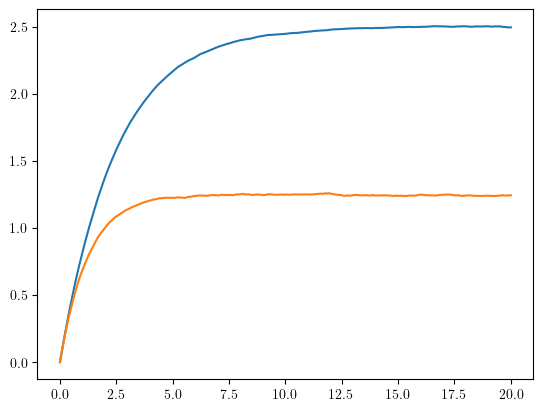

Final mean:  2.49375
Final var:   1.2435409374999244


In [10]:
means = np.mean(ranks, axis=0)
vars = np.var(ranks, axis=0)
plt.plot(ts, means)
plt.plot(ts, vars)
plt.show()
print("Final mean: ", means[-1])
print("Final var:  ", vars[-1])

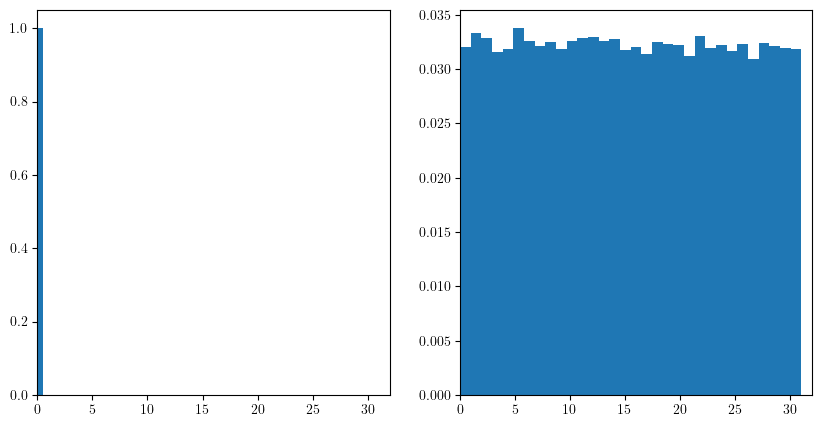

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(states[:, 0], density=True, bins=1)
ax[0].set_xlim(0, 32)
ax[1].hist(states[:, -1], density=True, bins=32)
ax[1].set_xlim(0, 32)
plt.show()

In [12]:
fig, ax = plt.subplots()
def update(frame):
    ax.clear()
    ax.hist(states[:, frame], density=True, bins=32)
    ax.set_xlim(0, 32)
anim = animation.FuncAnimation(fig, update, N_time_samples, interval=20)
plt.close()

In [13]:
display(anim)

## Multivariate Normal Fitting

In [14]:
d = 10
N = int(1e4)
L = np.zeros((d,d))
for i in range(d):
    for j in range(i+1):
        L[i,j] = 1/(i - j + 1)
L = np.array(L)
C = np.dot(L, L.T)
S = scipy.stats.multivariate_normal.rvs(np.zeros(d), C, size=N)

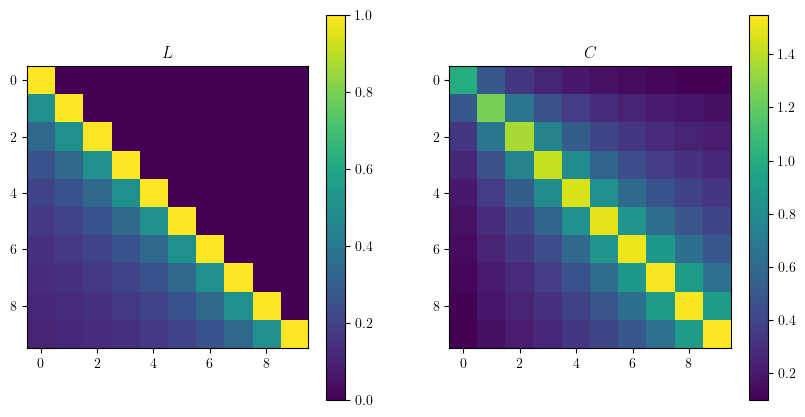

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
data0 = ax[0].imshow(L)
ax[0].set_title("$L$")
data1 = ax[1].imshow(C)
ax[1].set_title("$C$")
fig.colorbar(data0, ax=ax[0])
fig.colorbar(data1, ax=ax[1])
plt.show()

(array([  28.,  142.,  644., 1710., 2688., 2505., 1531.,  584.,  148.,
          20.]),
 array([-3.50963269, -2.80087954, -2.09212639, -1.38337324, -0.67462009,
         0.03413307,  0.74288622,  1.45163937,  2.16039252,  2.86914568,
         3.57789883]),
 <BarContainer object of 10 artists>)

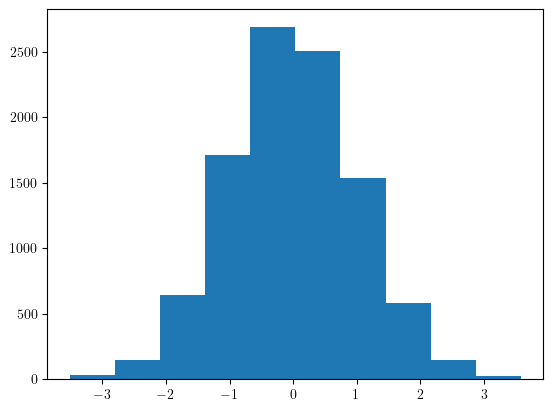

In [16]:
plt.hist(S[:,0])

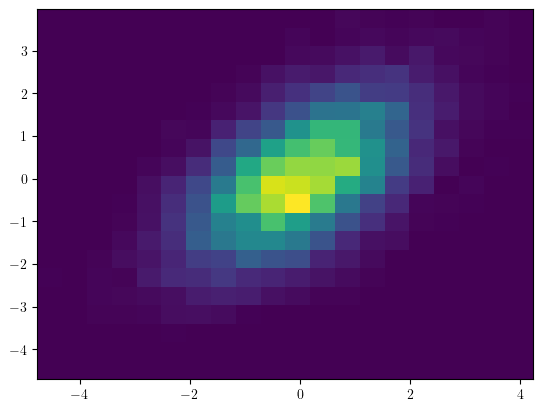

In [17]:
plt.hist2d(S[:,2], S[:,3], bins=(20,20))
plt.show()

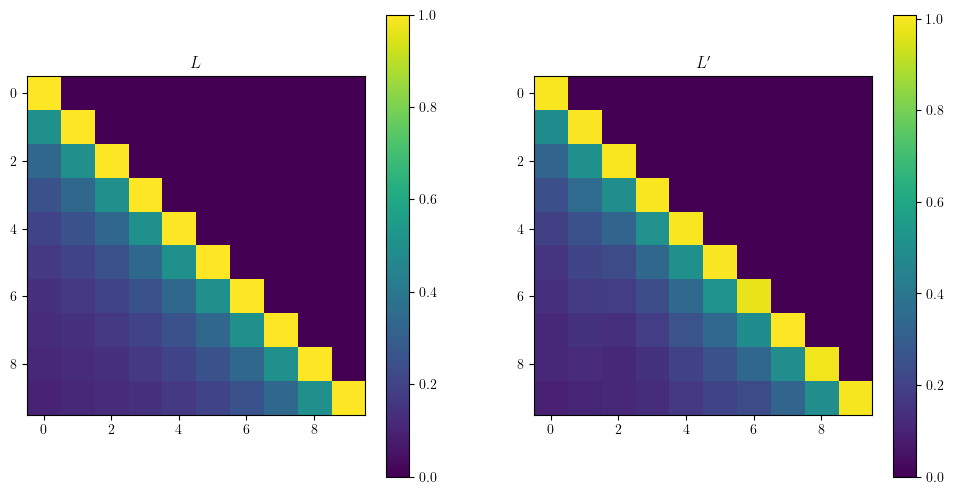

In [18]:
cov = np.cov(S.T)
L_prime = np.linalg.cholesky(cov)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data0 = ax[0].imshow(L)
ax[0].set_title("$L$")
data1 = ax[1].imshow(L_prime)
ax[1].set_title("$L'$")
fig.colorbar(data0, ax=ax[0])
fig.colorbar(data1, ax=ax[1])
plt.show()

In [19]:
error = L-L_prime
plt.imshow(foo, cmap=mpl.colormaps['seismic'])
plt.title("$L - L'$")
plt.colorbar()
plt.show()
error = np.linalg.norm(error.flatten())
print("Error: ", error)

NameError: name 'foo' is not defined